# 3 ML Model Predictions

# Imports & Functions

## Imports

In [1]:
# General imports
import os
import sys
import gc
import warnings
from typing import Literal

from datetime import datetime
from pprint import pprint
import time
import pickle
import cloudpickle
import joblib
import random
from collections import Counter

# Custom Functions
sys.path.append(os.path.abspath('../Notebooks/Utilities')) 
import cust_utilities as utils

# Maths, Pandas etc
import math
import numpy as np
import pandas as pd
import scipy as sci

# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.backends.backend_pdf import PdfPages

# ML Prep
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import make_column_selector

# ML Training
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import shap

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


## Functions - Results & Features Inspection

In [2]:
# Plots for subject info
#

def subject_info_plot(subjects_df):

    # PD & Gender
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    fig.suptitle('Study Subjects - PD & Gender', fontsize=18)

    counts = subjects_df['pd'].value_counts()
    axes[0].set_title('PD')
    axes[0].bar(counts.index.astype(str), counts.values, color=['skyblue', 'skyblue'], edgecolor='black')
    axes[0].set_xticks(range(len(counts.index)))
    axes[0].set_xticklabels(['Yes', 'No'])
    for i, (label, count) in enumerate(counts.items()):
        axes[0].text(i, count/2, str(count), ha='center', va='center', fontsize=12)

    counts = subjects_df['gender'].value_counts()
    axes[1].set_title('Gender')
    axes[1].bar(counts.index.astype(str), counts.values, color=['skyblue', 'skyblue'], edgecolor='black')
    axes[1].set_xticks(range(len(counts.index)))
    axes[1].set_xticklabels(['Male', 'Female'])
    for i, (label, count) in enumerate(counts.items()):
        axes[1].text(i, count/2, str(count), ha='center', va='center', fontsize=12)

    plt.tight_layout()
    plt.show()

    # Age Distribution & Box
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    fig.suptitle('Study Subjects - Age Distribution', fontsize=18)

    axes[0].hist(subjects_df['age'], bins=15, color='skyblue', edgecolor='black')

    axes[1].set_xticks([0])
    box = axes[1].boxplot(subjects_df['age'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    plt.tight_layout()
    plt.show()


In [3]:
# Plots for EEG Preprocessing Results
#

def eeg_preprocess_results_plot(results_df):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
    fig.suptitle('EEG Preprocessing Metrics - All Subjects', fontsize=18)

    # Quality Warning
    counts = results_df['EEG_preprocessing_quality_warning'].value_counts().reindex([True, False], fill_value=0)
    axes[0].set_title('Overall Quality Warning Count')
    axes[0].bar(counts.index.astype(str), counts.values, color=['salmon', 'lightgreen'], edgecolor='black')
    axes[0].set_xticks(range(len(counts.index)))
    axes[0].set_xticklabels(['Yes', 'No'])
    for i, (label, count) in enumerate(counts.items()):
        axes[0].text(i, count/2, str(count), ha='center', va='center', fontsize=12)

    # # Channels count
    # counts = results_df['channel_count'].value_counts()
    # axes[1].set_title('Channels Count')
    # axes[1].bar(counts.index.astype(str), counts.values, color=['skyblue'], edgecolor='black')

    # ICA Rejection Level
    axes[1].set_title('ICA - ICs Rejection Level')
    box = axes[1].boxplot(results_df['ICA_rejection_level'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    # Epoch Rejection Level
    axes[2].set_title('Epoch Rejection Level')
    box = axes[2].boxplot(results_df['epoch_rejection_level'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')
    # axes[2].set_xlabel('Epoch Rejection Level')
    # axes[2].set_ylabel('Number of Subjects')
    # axes[2].hist(results_df['epoch_rejection_level'], bins=10, color='skyblue', edgecolor='black')
    # nonzero_epoch_rejection = results_df['epoch_rejection_level'][results_df['epoch_rejection_level'] > 0]
    # axes[2].hist(nonzero_epoch_rejection, bins=15, color='salmon', edgecolor='black', alpha=0.7)
    # for bar in axes[2].patches:
    #     bar.set_width(bar.get_width() * 0.8)

    plt.tight_layout()
    plt.show()


In [4]:
# Plots for EEG SpecParam Results
#

def eeg_specparam_results_plot(results_df):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
    fig.suptitle('EEG SpecParam Fit Metrics - All Subjects', fontsize=18)

    # Quality Warning
    counts = results_df['chn_SPM_fit_quality_warning'].value_counts().reindex([True, False], fill_value=0)
    axes[0].set_title('Overall Quality Warning Count')
    axes[0].bar(counts.index.astype(str), counts.values, color=['salmon', 'lightgreen'], edgecolor='black')
    
    axes[0].set_xticks(range(len(counts.index)))
    axes[0].set_xticklabels(['Yes', 'No'])
    for i, (label, count) in enumerate(counts.items()):
        axes[0].text(i, count/2, str(count), ha='center', va='center', fontsize=12)

    # Error Mean
    axes[1].set_title('Error Mean')
    box = axes[1].boxplot(results_df['chn_error_mean'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    # R-Squared Mean
    axes[2].set_title('R2 Mean')
    box = axes[2].boxplot(results_df['chn_r2_mean'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    plt.tight_layout()
    plt.show()

    # Number of flagged channels
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(3, 4))
    # fig.suptitle('EEG SpecParam Fit Metrics - Flagged Channels', fontsize=18)
    flagged_counts = results_df['chn_flagged_channels'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    axes.set_title('Flagged Channels Count')
    box = axes.boxplot(flagged_counts, patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='salmon')

    plt.tight_layout()
    plt.show()

In [5]:
# Plots for Aperiodic Features Spread
#

def aperiodic_features_plot(results_df, level):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    fig.suptitle(f'Aperiodic Features - {level}', fontsize=18)

    # Offset
    axes[0].set_title('Offset')
    box = axes[0].boxplot(results_df['offset'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    # Exponent
    axes[1].set_title('Exponent')
    box = axes[1].boxplot(results_df['exponent'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    plt.tight_layout()
    plt.show()


In [6]:
# Plots for Periodic Features Spread
#

def periodic_features_plot(results_df, level):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
    fig.suptitle(f'Periodic Features - {level}', fontsize=18)

    # CF
    axes[0].set_title('CF_0')
    box = axes[0].boxplot(results_df['cf_0'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    # PW
    axes[1].set_title('PW_0')
    box = axes[1].boxplot(results_df['pw_0'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    # BW
    axes[2].set_title('BW_0')
    box = axes[2].boxplot(results_df['bw_0'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    plt.tight_layout()
    plt.show()


In [7]:
# Plots for Aperiodic Peaks Count 
#

def periodic_peaks_plot(results_df):

    regions_df = results_df[results_df['channel'].isnull()].copy()
    cf_cols = [col for col in regions_df.columns if col.startswith('cf_')]
    regions_df['num_periodic_cf'] = regions_df[cf_cols].notnull().sum(axis=1)
    
    channels_df = results_df[results_df['region'].isnull()].copy()
    cf_cols = [col for col in channels_df.columns if col.startswith('cf_')]
    channels_df['num_periodic_cf'] = channels_df[cf_cols].notnull().sum(axis=1)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    fig.suptitle(f'Periodic Peaks Count', fontsize=18)

    # Region
    axes[0].set_title('Regions')
    box = axes[0].boxplot(regions_df['num_periodic_cf'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    # Channel
    axes[1].set_title('Channels')
    box = axes[1].boxplot(channels_df['num_periodic_cf'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    plt.tight_layout()
    plt.show()


## Model 

In [8]:
# Model Evaluation
#

def evaluate_model(model, X_test, y_test, verbose=True):

    # Run predictions
    start_time = time.perf_counter()
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)
    duration = time.perf_counter() - start_time

    # Calculate Metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    recall = metrics.recall_score(y_true=y_test, y_pred=y_pred, pos_label=1)
    precision = metrics.precision_score(y_true=y_test, y_pred=y_pred, pos_label=1)
    f1_score = metrics.f1_score(y_true=y_test, y_pred=y_pred, pos_label=1)
    specificity = tn / (tn + fp)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Print Metrics
    if verbose:
        print(f'----Evaluation Result for: {model.model_name} -------')
        print(f'Recall (Sensitivity, TP Rate): {recall:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'F1 Score {f1_score:.4f}')
        print(f'Specificity (1 - Fall-Out): {specificity:.4f}')
        print(f'MCC: {mcc:.4f}')
        print('-----------')
        print(f'Accuracy: {metrics.accuracy_score(y_true=y_test, y_pred=y_pred):.4f}')
        print(f'Fall Out (FPR): {fp / (fp + tn):.4f}')
        print(f'Hamming Loss {metrics.hamming_loss(y_true=y_test, y_pred=y_pred):.4f}')
        roc_auc_score = metrics.roc_auc_score(y_true=y_test, y_score=y_probs[:,1])
        print(f'ROC-AUC Score {roc_auc_score:.4f}')
        gini_score = 2 * roc_auc_score - 1
        print(f'Gini Index: {gini_score:.4f}')
        print('-----------')

    # Plot Confusion Matrix & ROC Curve
    if verbose:
        plt.style.use('default')
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
        fig.suptitle(f'Model Prediction Evaluation', fontsize=20)

        axes[0].set_title('Confusion Matrix')    
        class_labels = model.classes_
        ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(ax=axes[0])
        axes[1].set_title('ROC Curve')
        # roc_display = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axes[1], pos_label=1)
        RocCurveDisplay.from_predictions(y_test, y_probs[:,1], ax=axes[1], pos_label=1)

        plt.tight_layout()
        plt.show()
        plt.style.use('ggplot')

    # Create Predications df With Confidences
    predicted_confidence = [y_probs[i, pred] for i, pred in enumerate(y_pred)]
    predictions_df = pd.DataFrame({
        'Ground_Truth': y_test,
        'Prediction': y_pred,
        'Confidence': predicted_confidence
        })
    # Highlight Mismatches
    if verbose:
        print('Mismatches')
        mismatches = predictions_df[predictions_df['Prediction'] != predictions_df['Ground_Truth']]
        display(mismatches)

    # Return Results
    results = {'study': 'test_study',
               'training_source_data_run': 'empty',
               'training_results_run': 'empty',
               'search_features_detail': 'empty',
               'search_features_selection': 'empty',
               'CV_search_time': 0,
               'CV_best_parameters': '{xx}',
               'features_detail': 'test region',
               'features_selection': 'test list',
               'model_name': model.model_name,
               'prediction_time': duration,
               'mcc': mcc,
               'recall': recall,
               'precision': precision,
               'f1_score': f1_score,
               'specificity': specificity
               }
    
    return results, predictions_df

# Study Load & Model

In [9]:
# Study Data & Model Details

#---- Parameters --------------------------------
# Study
# study_name = 'IOWA_Rest'
# eeg_features_run = '1b_EEG_Features_Results_Run_20250801_full_run'
# study_name = 'IOWA_Simon'
# eeg_features_run = '1b_EEG_Features_Results_Run_20250726_full_run'
study_name = 'UNM_Oddball'
eeg_features_run = '1b_EEG_Features_Results_Run_20250726_full_run'

# Model Name
# model_name = 'Random_Forest_Channel_Periodic'
# model_name = 'Logistic_Regression_Region_CF'
model_name = 'Support_Vector_Machine'

# Prediction Run Name
run_description = 'predictions_SVM_Region_Periodic'

# ml_training_run = '2_Feature_Selection_Training_Run_20250803_select_train_regions_aperiodic'
# test_mode = True
#----------------------------------------------------

# Get existing study details, if exists
study_folder_path = utils.get_folder_path('Study_' + study_name)
study_info = pd.read_pickle(study_folder_path + '/study_inf.pkl', compression='zip')
study_subjects_df = pd.read_pickle(study_folder_path + '/study_subjects_df.pkl', compression='zip')

# EEG Processing Results Data
eeg_features_run_results_path = utils.get_folder_path(study_info['eeg_processing_results_path'] + '/' + eeg_features_run)
eeg_features_run_details = pd.read_pickle(eeg_features_run_results_path + '/run_details.pkl', compression='zip')
eeg_preprocessing_run = eeg_features_run_details['eeg_preprocessed_data']

eeg_preprocessing_run_results_path = utils.get_folder_path(study_info['eeg_processing_results_path'] + '/' + eeg_preprocessing_run)
eeg_preprocessed_data_path = utils.get_folder_path(eeg_preprocessing_run_results_path + '/Cleaned_files' )
eeg_preprocessing_run_details = pd.read_pickle(eeg_preprocessing_run_results_path + '/run_details.pkl', compression='zip')
eeg_processing_results_df = pd.read_pickle(eeg_features_run_results_path + '/eeg_processing_results_df.pkl', compression='zip')
eeg_features_superset_df = pd.read_pickle(eeg_features_run_results_path + '/eeg_features_superset_df.pkl', compression='zip')
eeg_features_flattened_df = pd.read_pickle(eeg_features_run_results_path + '/eeg_features_flattened_df.pkl', compression='zip')
 
# Setup Predictions Results Folder
current_date = datetime.now().strftime('%Y%m%d')
run_name = f'3_Model_Predictions_Run_{current_date}_{run_description}'
# TODO: Add to study setuop & settings
# run_results_path = utils.extend_folder_path(study_info['ml_model_prdictions_results_path'], run_name, exists_ok=False)
temp_folder_path = study_folder_path +'/3_ML_Model_Predictions'
run_results_path = utils.extend_folder_path(temp_folder_path, run_name, exists_ok=False)

# Load ML Model
models_folder_path = utils.get_folder_path('Models_Selected')
grid_search = pickle.load(open(models_folder_path + '/' + 'grid_search_' + model_name + '.pkl', 'rb'))
model = pickle.load(open(models_folder_path + '/' + 'model_' + model_name + '.pkl', 'rb'))


In [10]:
# Processing Run Details & Data Structures
summary = f'EEG Processing Parameters'
summary = summary + f"\n- Study: {study_info['study_name']} {study_info['dataset_ref']}"
summary = summary + f"\n- EEG Processing Run: {eeg_preprocessing_run_details['run_name']}"
summary = summary + f"\n-   Preprocess Params: {eeg_preprocessing_run_details['preprocess_params']}"
summary = summary + f"\n-   ICA Params: {eeg_preprocessing_run_details['artefact_params']}"
summary = summary + f"\n- EEG Features Run: {eeg_features_run}"
summary = summary + f"\n-   PSD Params: {eeg_features_run_details['psd_params']}"
summary = summary + f"\n-   SpecParam Params: {eeg_features_run_details['specparam_params']}"
summary = summary + f'\nModel Predictions Run'
summary = summary + f"\n- Run: {run_name}"
summary = summary + f"\n- Model: {model_name}"

print(f'{summary}\n')


EEG Processing Parameters
- Study: UNM_Oddball ds003490-1.1.0
- EEG Processing Run: 1a_EEG_Preprocessing_Run_20250726_full_run
-   Preprocess Params: {'band_pass_lf': 1, 'band_pass_hf': 100, 'band_pass_method': 'iir', 'phase': 'zero', 'linear_detrend': 'linear', 'channel_referencing': 'average'}
-   ICA Params: {'ica_method': 'infomax', 'ICA_rejection_threshold': 0.8}
- EEG Features Run: 1b_EEG_Features_Results_Run_20250726_full_run
-   PSD Params: {'method': 'welch', 'fmin': 1, 'fmax': 100, 'exclude': []}
-   SpecParam Params: {'peak_width_limits': [1, 12], 'max_n_peaks': 6, 'min_peak_height': 0.1, 'peak_threshold': 2.0, 'aperiodic_mode': 'fixed', 'fit_window': [2, 40], 'fit_error_threshold': 0.1, 'fit_r2_threshold': 0.9}
Model Predictions Run
- Run: 3_Model_Predictions_Run_20250819_predictions_SVM_Region_Periodic
- Model: Support_Vector_Machine



# Study Inspections

EEG Processing Results
(50, 23)


,subject_id,EEG_preprocessing_quality_warning,channel_count,ICA_components_count,ICA_rejection_level,epochs_count,epoch_rejection_level,reg_SPM_fit_quality_warning,reg_spectra_count,reg_null_fits,...,reg_peaks_count_max,reg_peaks_count_mean,chn_SPM_fit_quality_warning,chn_spectra_count,chn_null_fits,chn_error_mean,chn_r2_mean,chn_flagged_channels,chn_peaks_count_max,chn_peaks_count_mean
0,sub-001,False,63,62,0.419355,585,0.0,True,3,0,...,2,1.333333,True,63,0,0.050819,0.874244,[],3,1.111111
1,sub-002,False,63,62,0.16129,639,0.0,False,3,0,...,2,2.0,False,63,0,0.029686,0.986828,[],4,2.238095
2,sub-003,False,63,62,0.096774,670,0.029851,False,3,0,...,2,1.666667,True,63,0,0.041799,0.970826,[54],4,2.063492
3,sub-004,False,63,62,0.16129,660,0.0,False,3,0,...,2,1.333333,False,63,0,0.037766,0.983974,[],4,1.571429
4,sub-005,False,63,62,0.177419,404,0.0,False,3,0,...,3,2.0,False,63,0,0.0357,0.937695,[],3,1.984127


Null Fits: 0


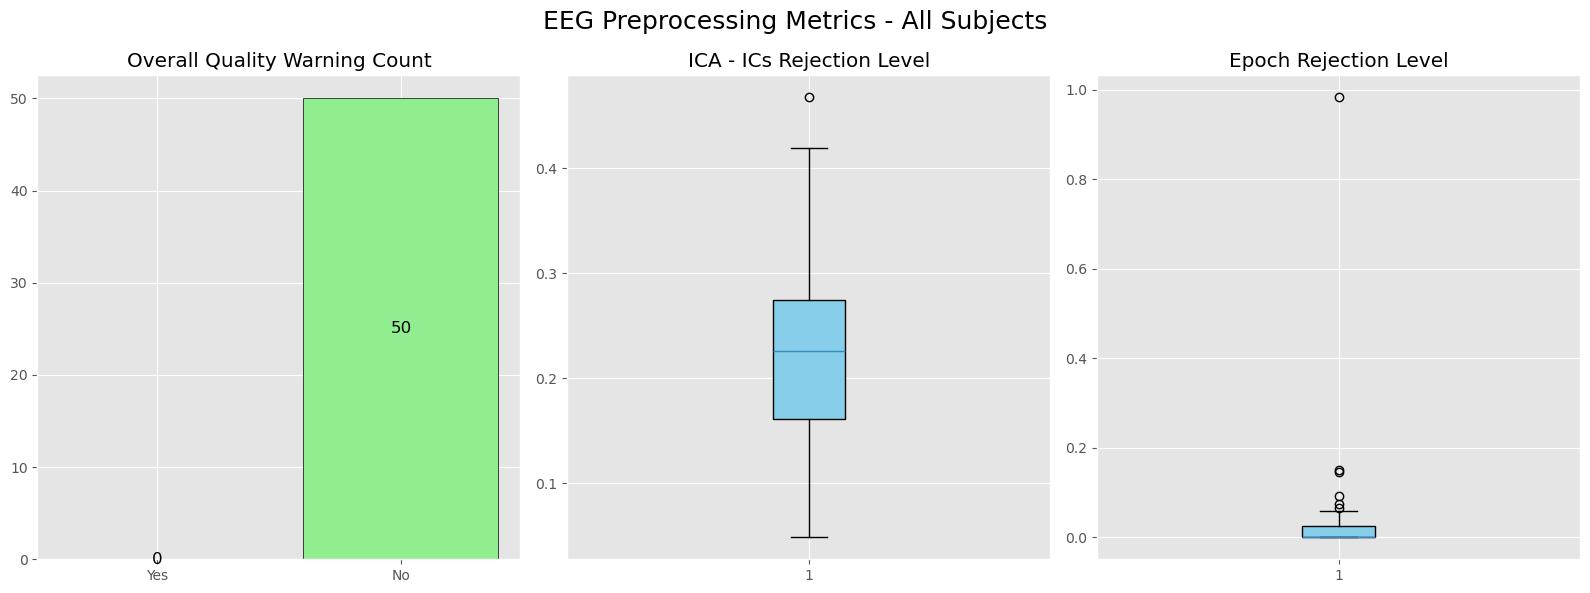

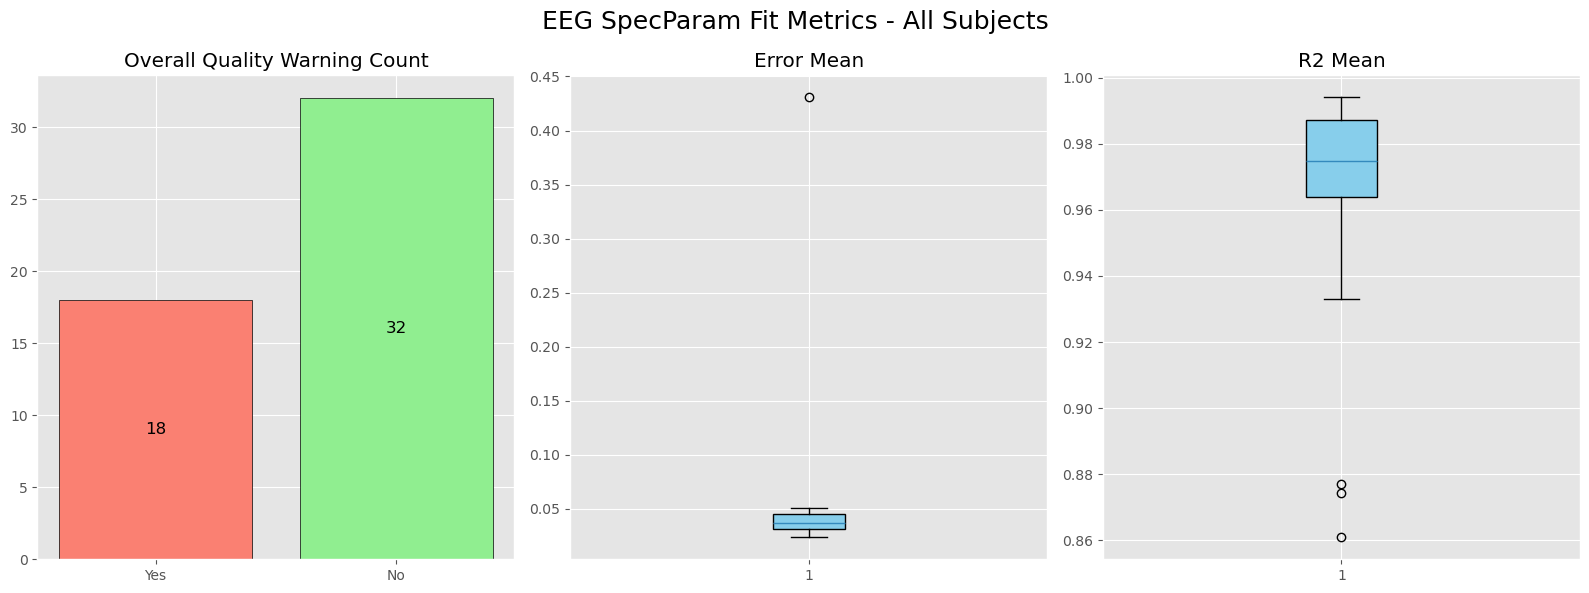

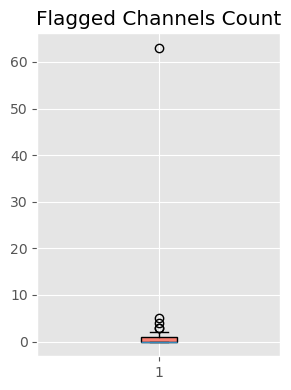

Study Subjects
(50, 5)


,study_name,subject_id,pd,age,gender
0,UNM_Oddball,sub-001,1,75,Male
1,UNM_Oddball,sub-002,1,79,Male
2,UNM_Oddball,sub-003,0,83,Female
3,UNM_Oddball,sub-004,1,79,Female
4,UNM_Oddball,sub-005,0,67,Female


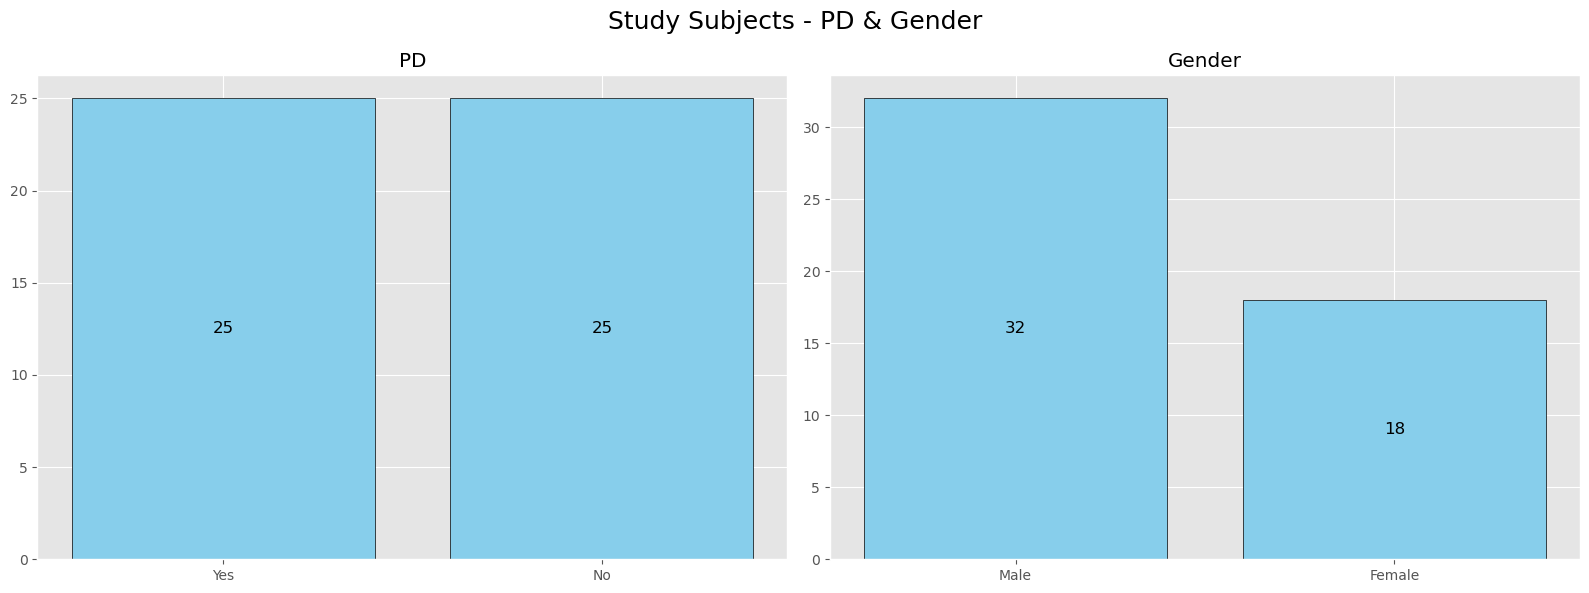

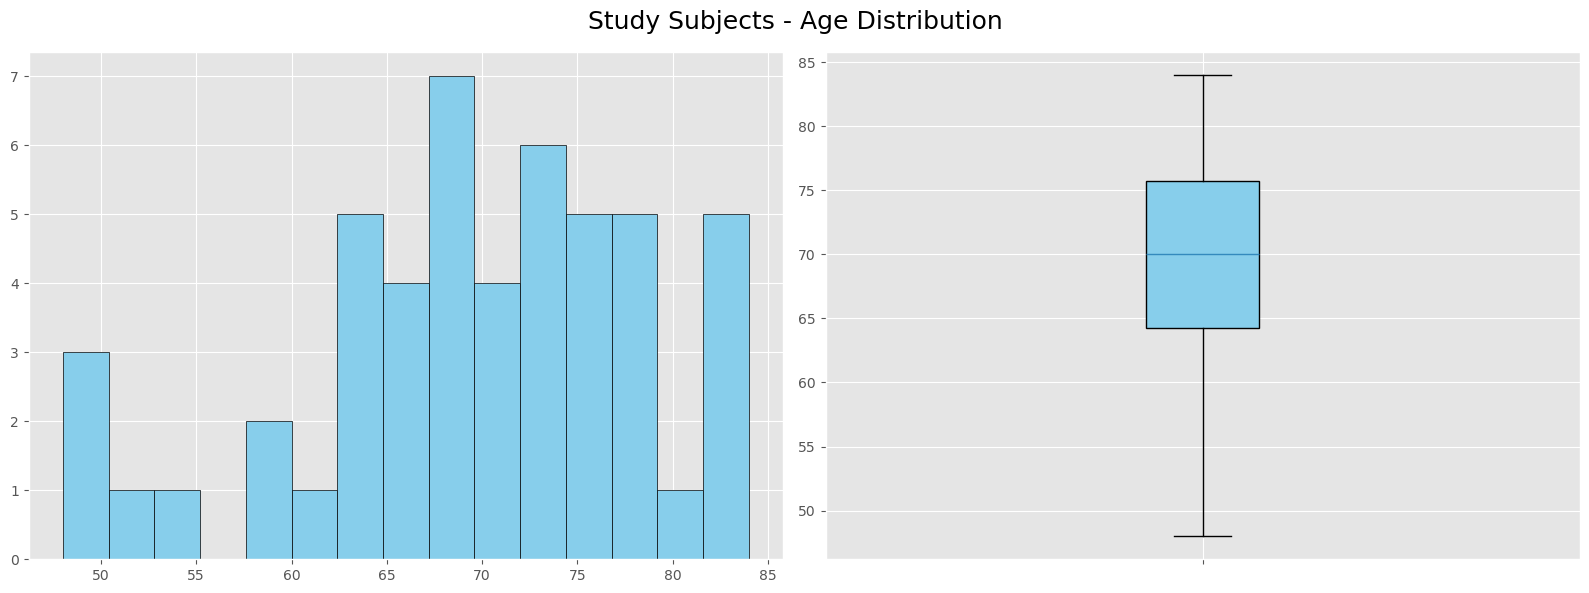

EEG Features Superset
(3350, 25)


,subject_id,region,channel,offset,exponent,cf_0,pw_0,bw_0,cf_1,pw_1,...,pw_3,bw_3,cf_4,pw_4,bw_4,cf_5,pw_5,bw_5,error,r_squared
0,sub-001,frontal,NaN,-11.987010,0.935744,9.078307,0.504145,2.000002,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.048435,0.969705
1,sub-001,central,NaN,-13.745427,0.348987,8.957153,0.143062,2.000000,31.474748,0.124083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.045535,0.737454
2,sub-001,posterior,NaN,-12.125291,0.713073,9.078938,0.546876,2.000004,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.059239,0.939782
3,sub-001,NaN,Fp1,-11.876780,0.808641,9.074499,0.509321,2.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.064751,0.933532
4,sub-001,NaN,Fz,-11.858531,1.103064,9.043711,0.441795,2.442932,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.023186,0.994682


EEG Features Flattened
(50, 1478)


,subject_id,pd,age,gender,region_frontal_offset,region_frontal_exponent,region_frontal_cf_0,region_frontal_pw_0,region_frontal_bw_0,region_frontal_cf_1,...,channel_CPz_pw_3,channel_CPz_bw_3,channel_CPz_cf_4,channel_CPz_pw_4,channel_CPz_bw_4,channel_CPz_cf_5,channel_CPz_pw_5,channel_CPz_bw_5,channel_CPz_error,channel_CPz_r_squared
0,sub-001,1,75,Male,-11.987010,0.935744,9.078307,0.504145,2.000002,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sub-002,1,79,Male,-11.852403,1.031429,11.514947,0.661479,5.001772,18.152469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sub-003,0,83,Female,-11.375444,1.095093,10.203731,0.487993,3.553690,18.695601,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sub-004,1,79,Female,-11.732272,1.095720,8.110969,0.366408,2.171504,10.804277,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sub-005,0,67,Female,-11.905289,0.806351,11.377282,0.419797,4.322692,18.393534,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


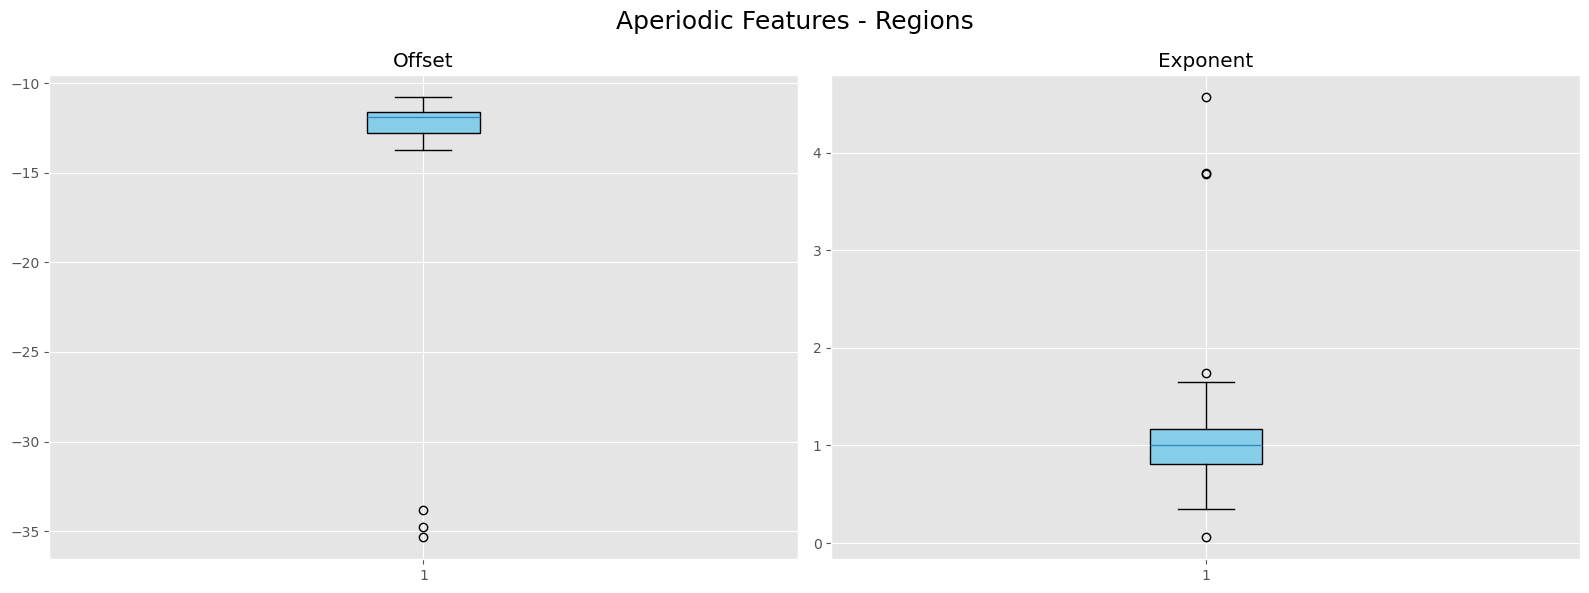

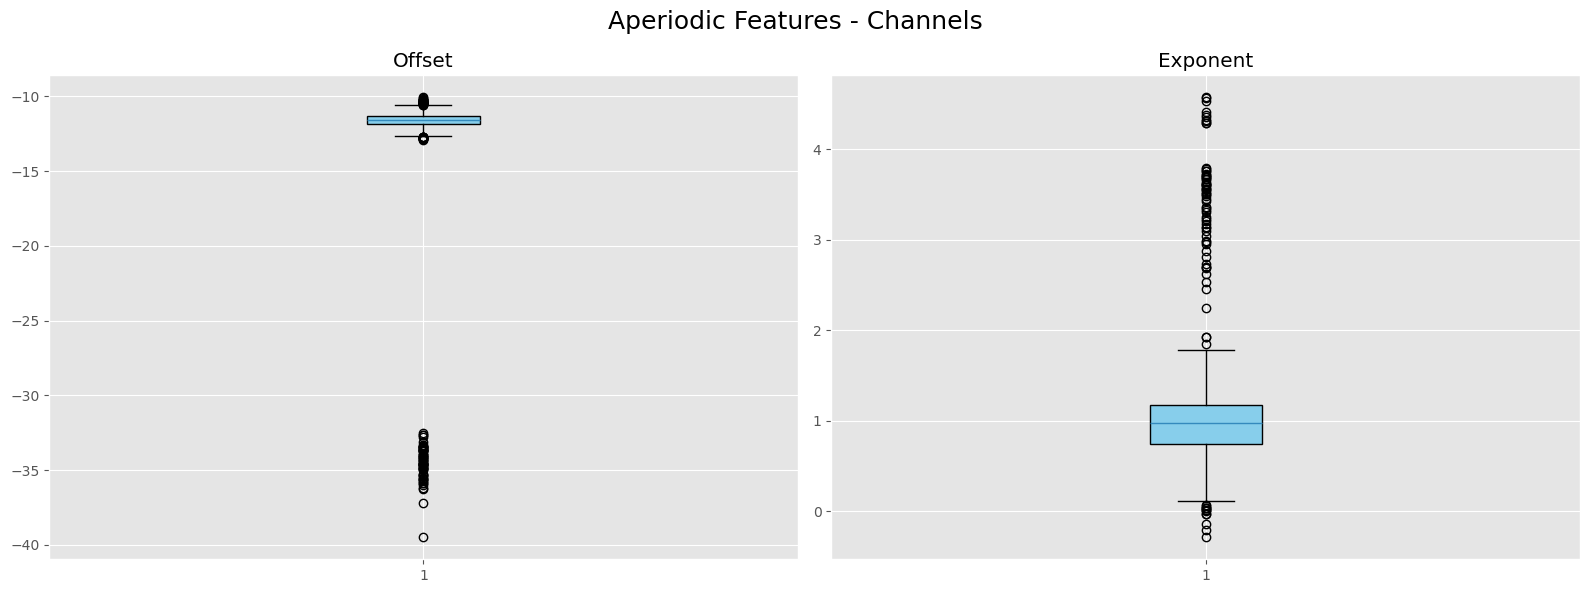

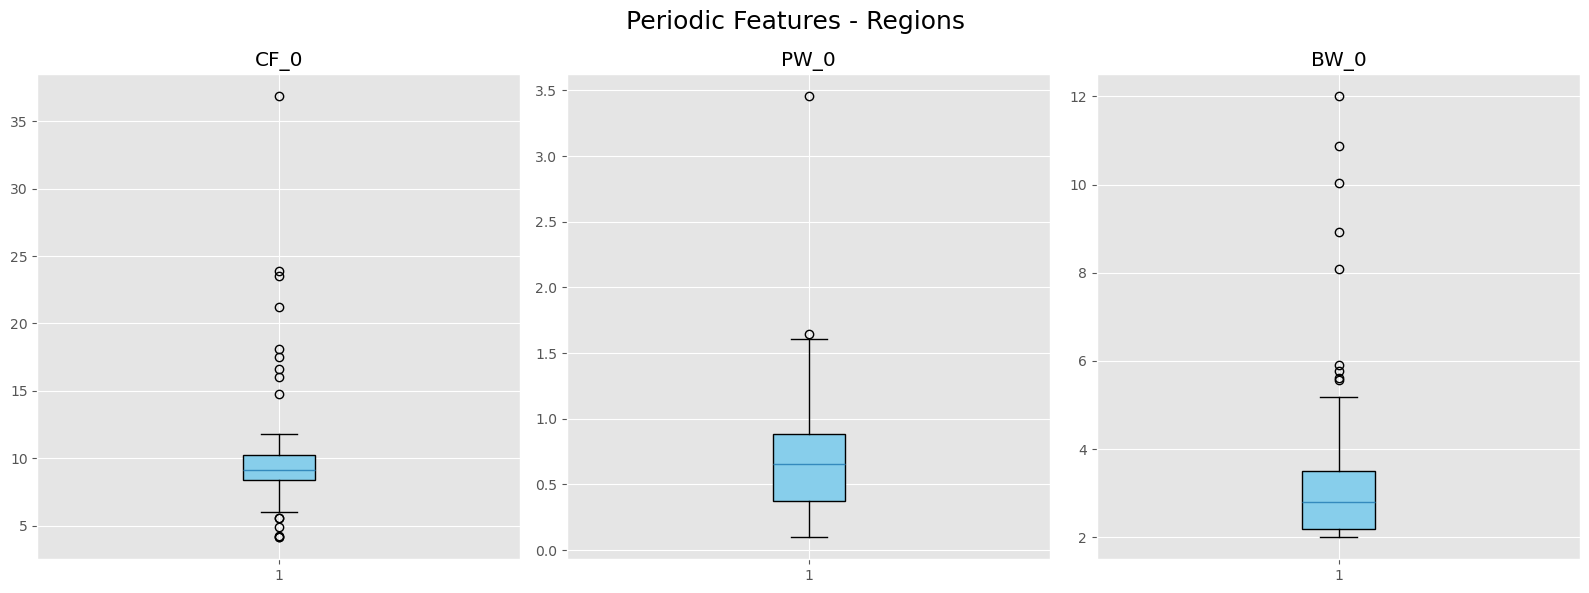

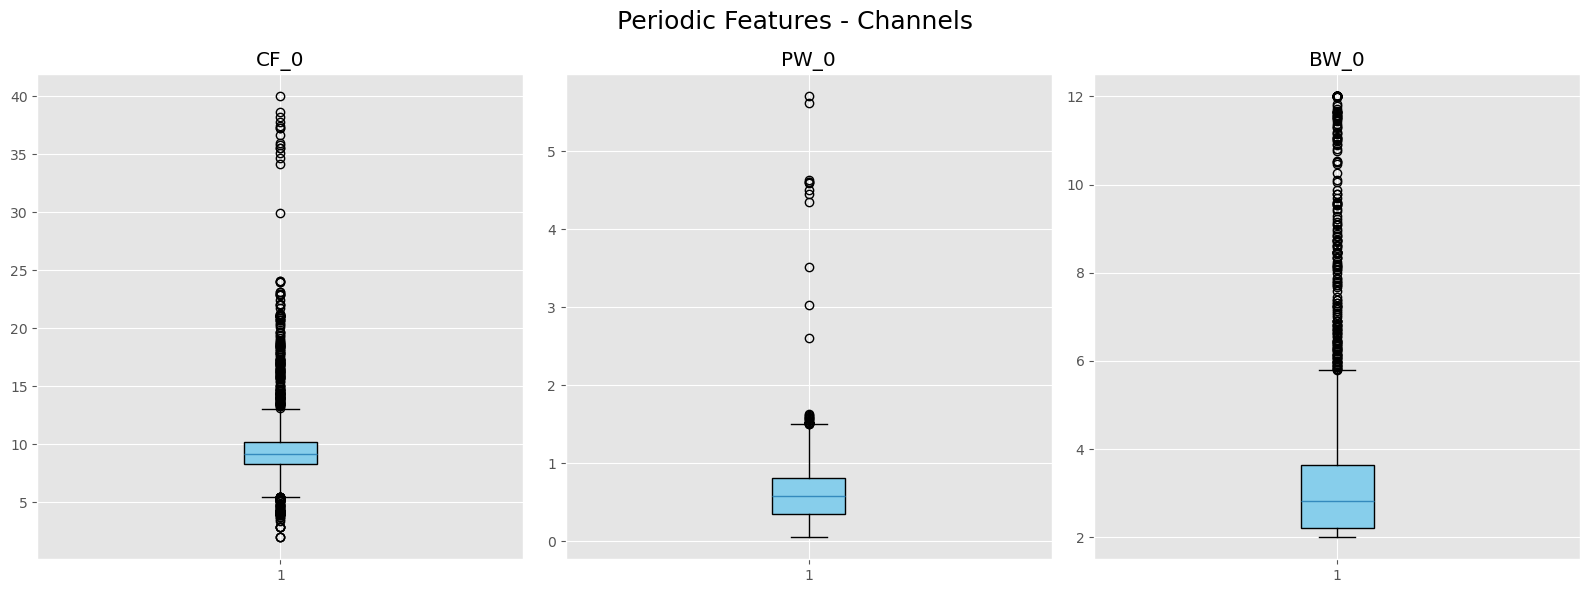

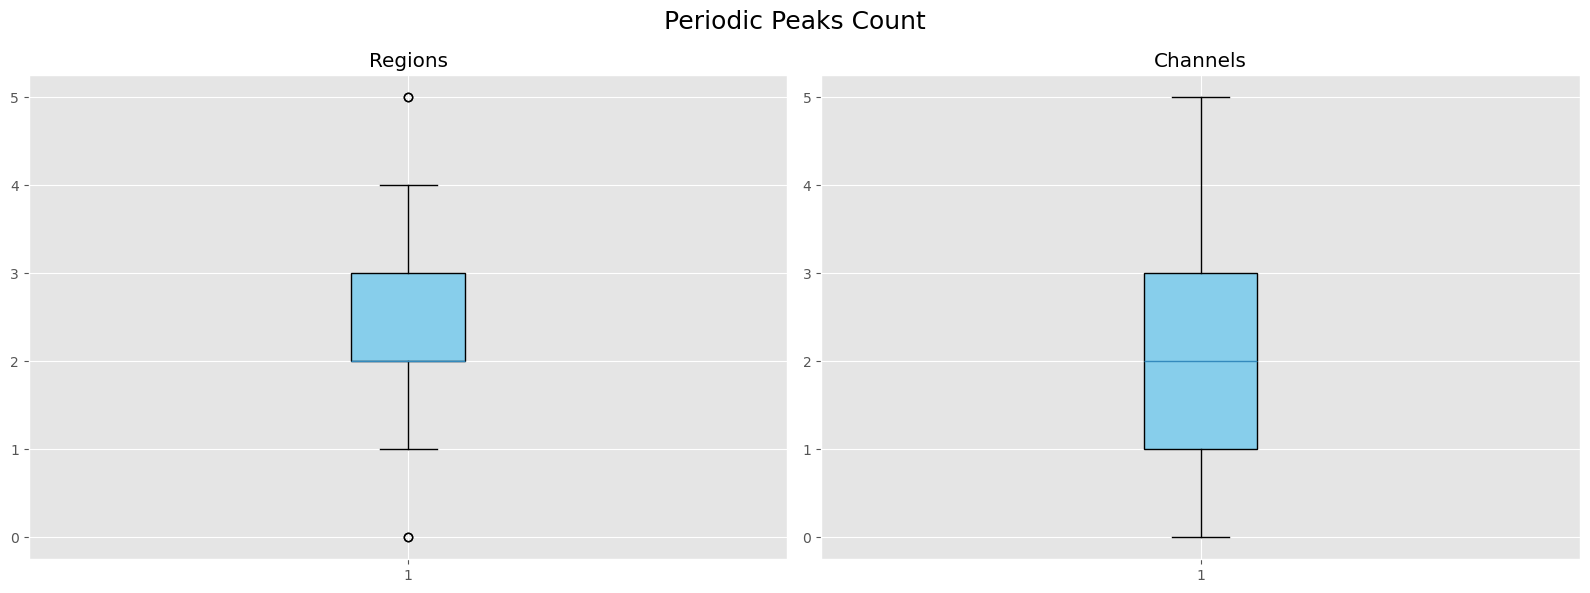

In [11]:
# Processing Metrics
print('EEG Processing Results')
print(eeg_processing_results_df.shape)
display(eeg_processing_results_df.head())

print(f'Null Fits: {sum(eeg_processing_results_df["chn_null_fits"])}')
eeg_preprocess_results_plot(eeg_processing_results_df)
eeg_specparam_results_plot(eeg_processing_results_df)

# Study Subjects Summary
print('Study Subjects')
print(study_subjects_df.shape)
display(study_subjects_df.head())

subject_info_plot(study_subjects_df)

# Features Superset 
print('EEG Features Superset')
print(eeg_features_superset_df.shape)
display(eeg_features_superset_df.head())

# Features Flattened 
print('EEG Features Flattened')
print(eeg_features_flattened_df.shape)
display(eeg_features_flattened_df.head())

# Features - At Region & Channel Detail Level
regions_df = eeg_features_superset_df[eeg_features_superset_df['channel'].isnull()].copy()
channels_df = eeg_features_superset_df[eeg_features_superset_df['region'].isnull()].copy()

aperiodic_features_plot(regions_df, 'Regions')
aperiodic_features_plot(channels_df, 'Channels')

periodic_features_plot(regions_df, 'Regions')
periodic_features_plot(channels_df, 'Channels')

periodic_peaks_plot(eeg_features_superset_df)

# Model Run & Predictions

## Model Details

In [12]:
# Grid Search & Model Details

# Grid Search Details
print("Grid Search")
print(grid_search)
print(f'\nBest parameters: \n{grid_search.best_params_}')
print("Best cross-validation score:", grid_search.best_score_)

# ML Model Details
print('\nModel Pipeline Steps')
for name, step in model.named_steps.items():
    print(f"- {name}: {step}")
print('\nAll Pipeline Parameters:')
for param, value in model.get_params().items():
    print(f"- {param}: {value}")

Grid Search
GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('features_selection',
                                        FeatureSelection()),
                                       ('data_preprocess',
                                        Pipeline(steps=[('data_preprocess',
                                                         ColumnTransformer(transformers=[('numeric',
                                                                                          Pipeline(steps=[('impute',
                                                                                                           SimpleImputer(fill_value=0,
                                                                                                                         keep_empty_features=True,
                                                                                                                         strategy='constant')),
          

## Run Predictions

In [13]:
# Separate X features and y target
# For Data Pipeline & ML Model Training
#

target_col_name = 'pd'
feature_names = eeg_features_flattened_df.columns[eeg_features_flattened_df.columns != target_col_name]
X = eeg_features_flattened_df[feature_names].copy()
y = eeg_features_flattened_df[target_col_name].copy()



----Evaluation Result for: SVM_v1 -------
Recall (Sensitivity, TP Rate): 0.7200
Precision: 0.5294
F1 Score 0.6102
Specificity (1 - Fall-Out): 0.3600
MCC: 0.0857
-----------
Accuracy: 0.5400
Fall Out (FPR): 0.6400
Hamming Loss 0.4600
ROC-AUC Score 0.6224
Gini Index: 0.2448
-----------


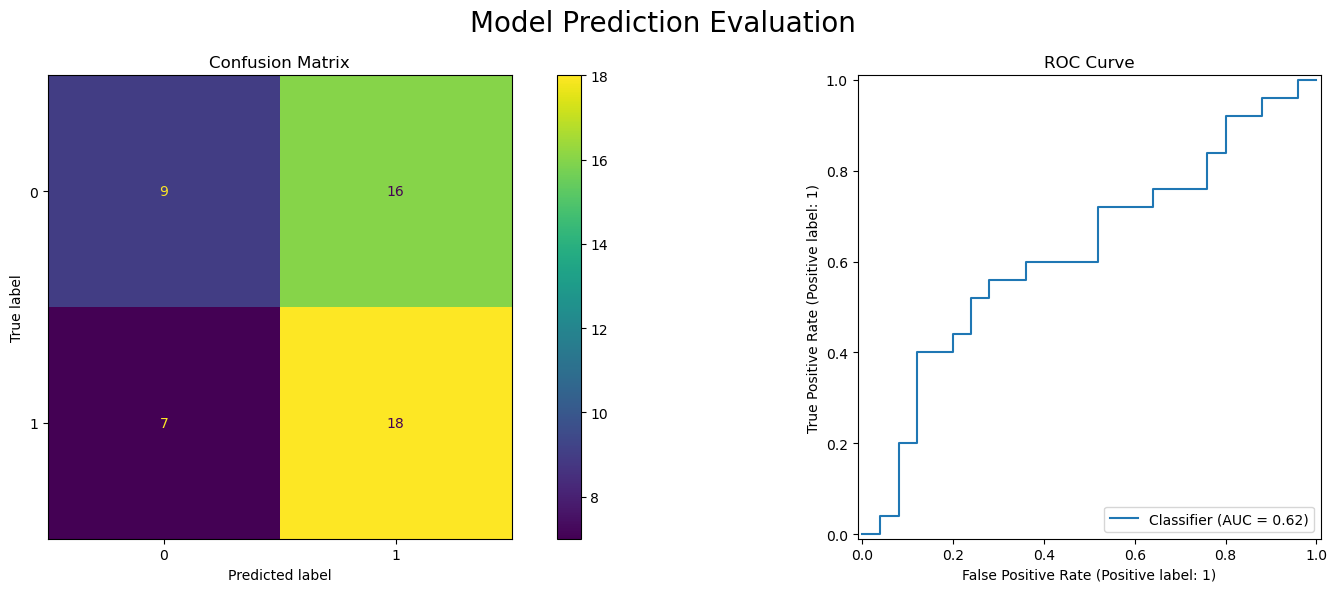

Mismatches


,Ground_Truth,Prediction,Confidence
0,1,0,0.381310
1,1,0,0.431907
2,0,1,0.656622
6,1,0,0.410465
7,1,0,0.411976
8,1,0,0.458409
13,1,0,0.426827
15,1,0,0.564087
28,0,1,0.631085
31,0,1,0.676412


,study,training_source_data_run,training_results_run,search_features_detail,search_features_selection,CV_search_time,CV_best_parameters,features_detail,features_selection,model_name,prediction_time,mcc,recall,precision,f1_score,specificity
0,UNM_Oddball,empty,empty,empty,empty,0,"{'classifier__C': 100, 'classifier__class_weig...",region,"[cf, pw, bw]",SVM_v1,0.009449,0.085749,0.72,0.529412,0.610169,0.36


In [14]:
# Model Predictions & Evaluation
#

eval_results, predictions_df = evaluate_model(model, X, y)

# Append Metrics
models_results = []
eval_results['study'] = study_name
# eval_results['training_source_data_run'] = eeg_features_run
# eval_results['training_results_run'] = run_name,
# eval_results['search_features_detail'] = detail_level_params,
# eval_results['search_features_selection'] = features_selected,
# eval_results['CV_search_time'] = search_duration
best_params = grid_search.best_params_
eval_results['CV_best_parameters'] = best_params
eval_results['features_detail'] = best_params.get('features_selection__features_detail_level')
eval_results['features_selection'] = best_params.get('features_selection__selected_features')
models_results.append(eval_results)
models_results_df = pd.DataFrame(models_results)
display(models_results_df)
models_results_df.to_pickle(run_results_path + '/predictions_results_df.pkl', compression='zip') 

